In [1]:
from bitarray import bitarray
import random
import numpy as np
import math

In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

In [4]:
import pandas as pd
import os

In [5]:
from sklearn import datasets

In [6]:
bcancer = datasets.load_breast_cancer()
X = bcancer.data  
y = bcancer.target

In [7]:
x_neg=X[y==0]
x_pos=X[y==1]
y_pos=y[y==1]
y_neg=y[y==0]
np.random.shuffle(x_neg)
print(x_neg.shape)
print(x_pos.shape)

(212, 30)
(357, 30)


In [8]:
indices=np.arange(106)
#x_train=np.array(x_neg[0:106])[indices]
y_train=y_neg[0:106]
x_train=np.concatenate((np.array(x_neg[0:106])[indices],x_pos)).reshape(-1,30)
y_train=np.concatenate((y_train,y_pos)).reshape(-1,1)

In [9]:
x_test = x_neg[106:212].reshape(-1,30)
y_test = y_neg[106:212].reshape(-1,1)

In [10]:
x_train = StandardScaler().fit_transform(x_train)

In [11]:
fpr_values_kraska = []
size_values_kraska = []

# Kraska Hash Model

In [12]:
class Kraska_Hash_BloomFilter:
    
    def __init__(self, size, model): #hash count is 1
        self.size = size
      #  self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)
        self.model=model #classifier model associated as hash function
        
    def add(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(model.predict(num)[0]*(self.size-1))    
        self.bit_array[result] = 1
            
    def lookup(self, num):
        #for seed in range(1,self.hash_count+1):
            #result = mmh3.hash(str(num), seed) % self.size
        result=math.floor(self.model.predict(num)[0]*(self.size-1))    
        if self.bit_array[result] == 0:
                return False
        return True

    def add_init(self,x_train,y_train):
        pred = self.model.predict(x_train)
        for i in range(len(pred)):
            if(y_train[i]==1):
                result = math.floor(pred[i][0]*(self.size-1))
                self.bit_array[result] = 1

    def predict(self,x):
        initpred = self.model.predict(x)
        indexes = []
        for i in range(len(initpred)):
            indexes += [math.floor(initpred[i][0]*(self.size-1))]
        pred = []
        for i in indexes:
            pred += [self.bit_array[i]]
        return np.array(pred)

#adds ratio r of an array of random integers of size n to bloom filter bf(input : bf,size,ratio; output: data array)
def addrandom(bf,n,r):
    data=np.empty(n,dtype=int)
    for i in range(0,n):
        data[i]=random.randint(0, 100000000)
    for j in range(0,int(n*r)):
        bf.add(data[j])
    return data

#(Input:bloom filter,number array,ratio of positives; Output:(-1) for false negative, otherwise fpr)
def fpr_kraska_hash(bf,x_test,y_test):
    pred = bf.predict(x_test)
    tn, fp, fn, tp = confusion_matrix(y_test,pred,labels=[False,True]).ravel() 
    return fp/(fp+tn)

#(Input:bloom filter size, total random numbers, ratio of number inserted; Output:efficient number of hash functions)
def eff_k(m,n,r):
    k=int(m/(int(n*r))*math.log(2))
    if(k==0):
        return 1
    return k

#(Input:size of bloom filter, number of hash functions, total numbers, ratio of numbers inserted; Output: fpr)
def find_fpr(m,model,n,r):
    bf=Kraska_Hash_BloomFilter(model,m)
    data=addrandom(bf,n,r)
    return fpr(bf,data,r)

#(Input:size of bloom filter, total numbers, ratio of numbers inserted; Output: prints inputs and fpr)
def outputs(m,n,r):
    find_fpr(m,model,n,r)
    #print("For m=%d, k=%d, n=%d, r=%.3f: fpr=%.3f"%(m,k,n,r,find_fpr(m,k,n,r)))

In [13]:
def get_data_points_Kraska(x_train,y_train,x_test,y_test,init_size,diff,num,epochs,fpr_values_kraska,size_values_kraska):
    batch_size = len(x_train)
    input_dim = x_train.shape[1]
    additional_metrics = ['acc']
    loss_function = BinaryCrossentropy()
    optimizer = Adam()
    verbosity_mode = 0
    average_over = 3   # Increase to make the graph smoother
    for i in range(0,num):
        layer_size = init_size + (diff*i)
        number_of_epochs = epochs
        sum_fpr = 0
        model_size = ((input_dim+1)*layer_size + (layer_size+1))*32
        m = int(model_size) + 1
        net_size = model_size + m

        for j in range(0,average_over):
            model = Sequential()
            model.add(Dense(layer_size,input_dim=input_dim,activation='relu'))
            model.add(Dense(1,activation='sigmoid'))
            model.compile(optimizer=optimizer, loss=loss_function, metrics=additional_metrics)
            history = model.fit(x_train, y_train, batch_size = batch_size, epochs=number_of_epochs, verbose=verbosity_mode)
            if(j==0):
                print("Number of nodes: %d" %(init_size + (diff*i)))
                plt.plot(history.history['acc'])
                plt.title('model accuracy')
                plt.ylabel('accuracy')
                plt.xlabel('epoch')
                plt.show()
                plt.plot(history.history['loss'])
                plt.title('model loss')
                plt.ylabel('loss')
                plt.xlabel('epoch')
                plt.show()
            
            bf=Kraska_Hash_BloomFilter(m,model)
            bf.add_init(x_train,y_train)
            sum_fpr += fpr_kraska_hash(bf,x_test,y_test)
        
        fpr = sum_fpr/average_over

        print("Size: %f bits - FPR: %f \n\n\n" % (net_size,fpr))
        fpr_values_kraska += [fpr]
        size_values_kraska += [net_size]

Number of nodes: 1


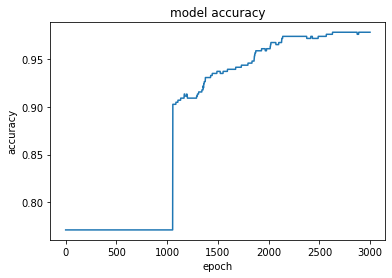

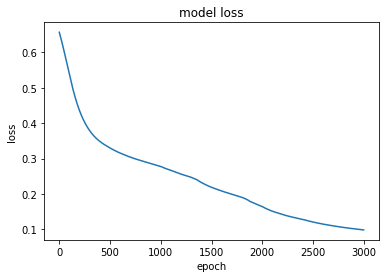

Size: 2113.000000 bits - FPR: 0.333333 



Number of nodes: 2


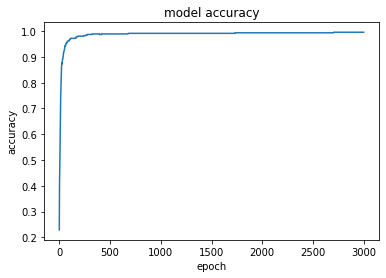

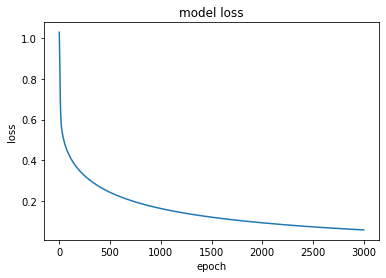

Size: 4161.000000 bits - FPR: 0.000000 



Number of nodes: 3


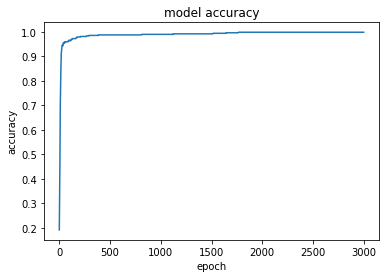

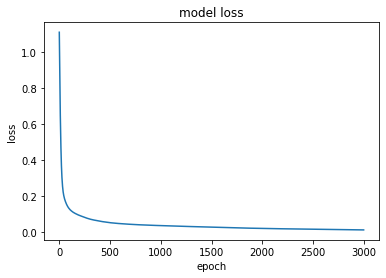

Size: 6209.000000 bits - FPR: 0.000000 



Number of nodes: 4


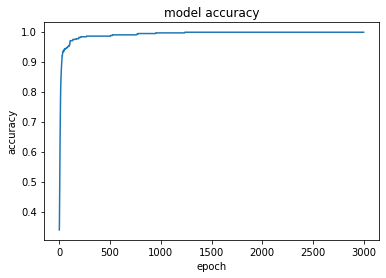

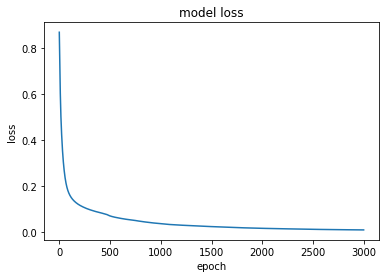

Size: 8257.000000 bits - FPR: 0.000000 



Number of nodes: 5


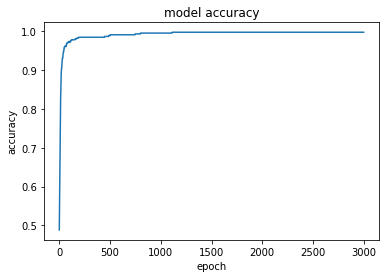

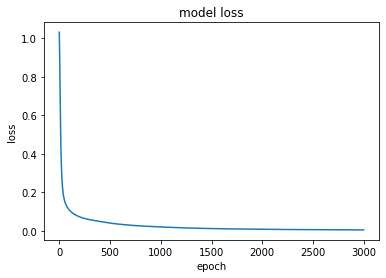

Size: 10305.000000 bits - FPR: 0.000000 



Number of nodes: 6


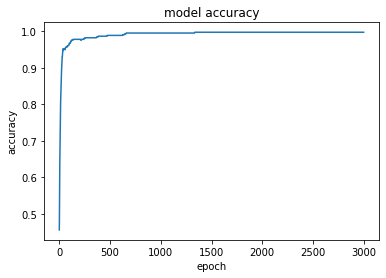

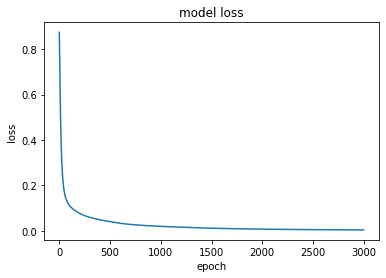

Size: 12353.000000 bits - FPR: 0.000000 



Number of nodes: 7


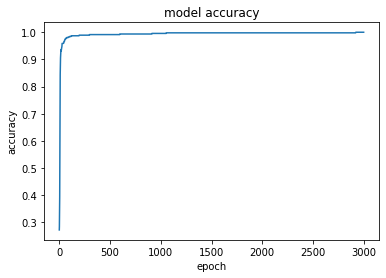

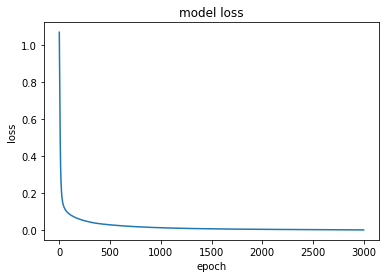

Size: 14401.000000 bits - FPR: 0.000000 



Number of nodes: 8


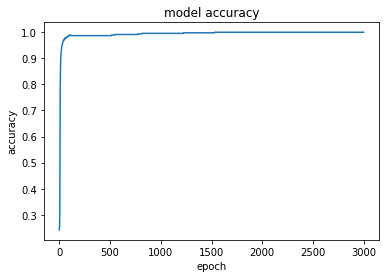

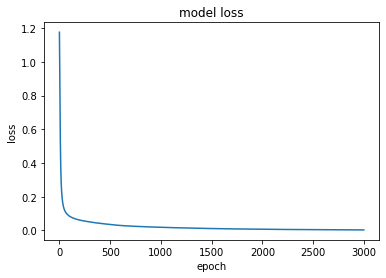

Size: 16449.000000 bits - FPR: 0.000000 



Number of nodes: 9


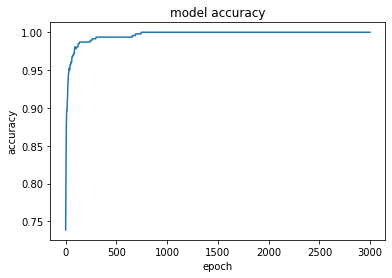

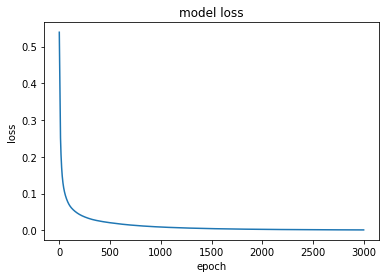

Size: 18497.000000 bits - FPR: 0.000000 



Number of nodes: 10


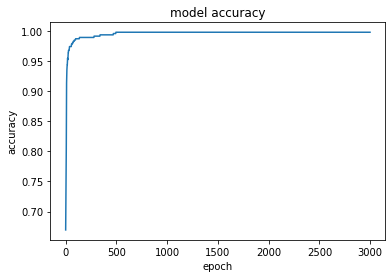

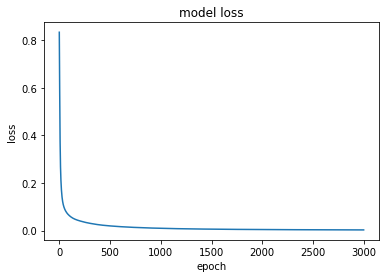

Size: 20545.000000 bits - FPR: 0.000000 



Number of nodes: 11


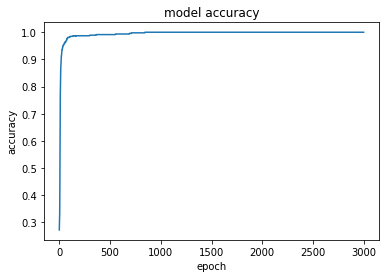

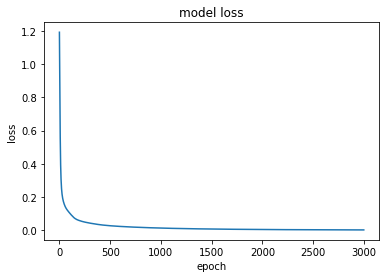

Size: 22593.000000 bits - FPR: 0.000000 



Number of nodes: 12


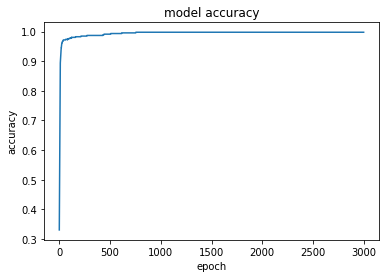

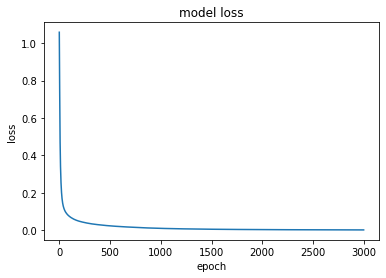

Size: 24641.000000 bits - FPR: 0.000000 



Number of nodes: 13


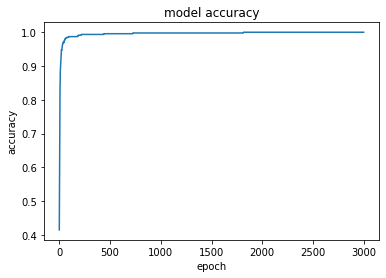

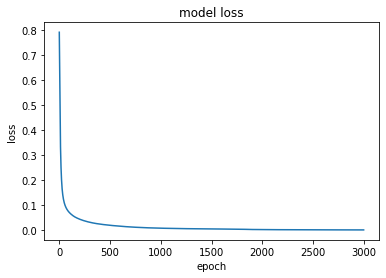

Size: 26689.000000 bits - FPR: 0.000000 



Number of nodes: 14


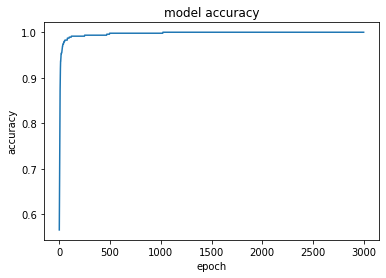

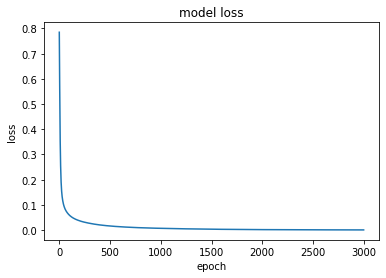

Size: 28737.000000 bits - FPR: 0.000000 



Number of nodes: 15


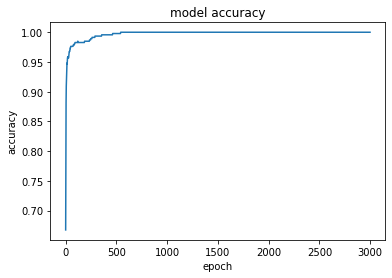

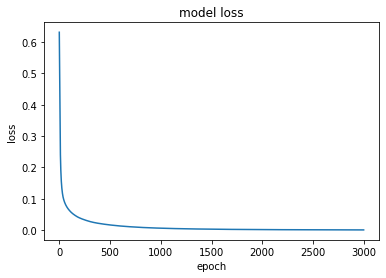

Size: 30785.000000 bits - FPR: 0.000000 



Number of nodes: 16


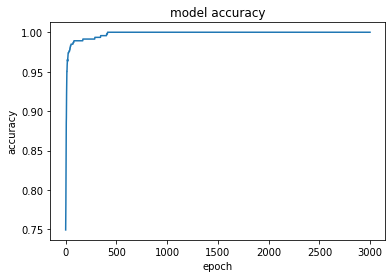

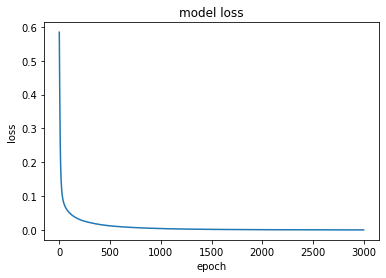

Size: 32833.000000 bits - FPR: 0.000000 



Number of nodes: 17


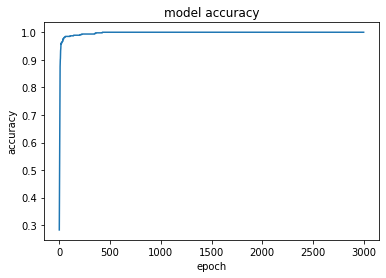

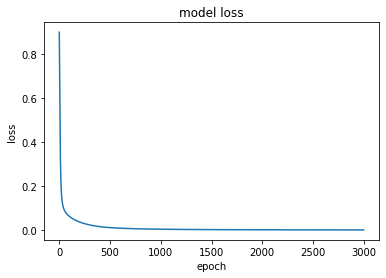

Size: 34881.000000 bits - FPR: 0.000000 



Number of nodes: 18


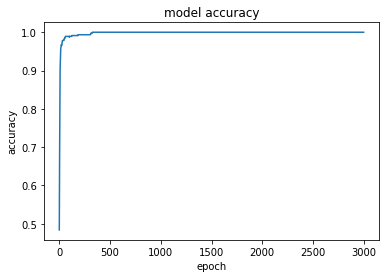

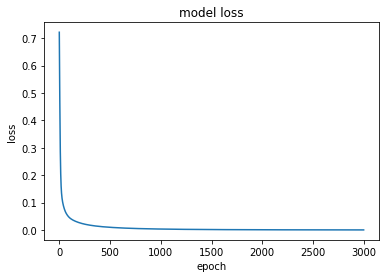

Size: 36929.000000 bits - FPR: 0.000000 



Number of nodes: 19


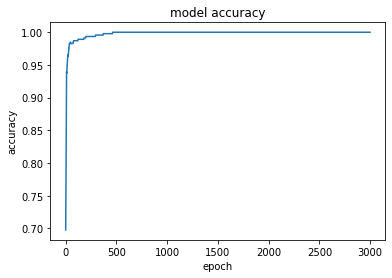

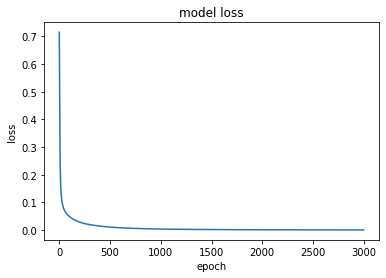

Size: 38977.000000 bits - FPR: 0.000000 



Number of nodes: 20


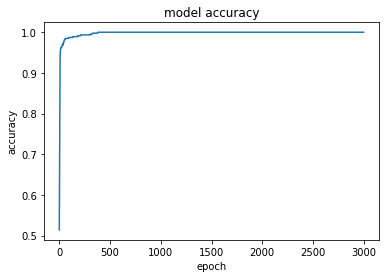

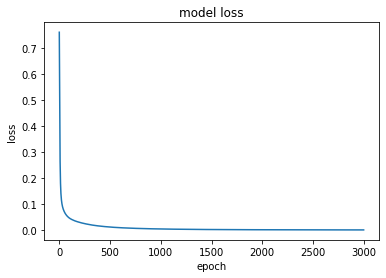

Size: 41025.000000 bits - FPR: 0.000000 





In [14]:
get_data_points_Kraska(x_train,y_train,x_test,y_test,1,1,20,3000,fpr_values_kraska,size_values_kraska)

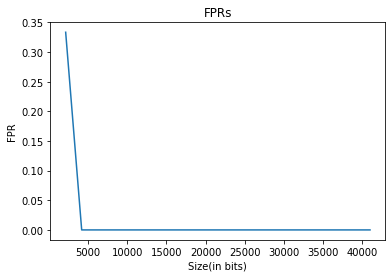

In [15]:
plt.plot(size_values_kraska,fpr_values_kraska)
plt.title('FPRs')
plt.xlabel('Size(in bits)')
plt.ylabel('FPR')
plt.show()

# Projection model

In [16]:
class Projection_BloomFilter:
    def __init__(self, size, hash_count, dim):
        vectors = np.random.normal(0,1,size=(hash_count,dim)) #random vectors(each row) from normal distribution, not unit vectors
        i=0
        while(i<hash_count):
            if(vectors[i][0]<0):
                vectors[i][0] *= -1
               # print("initial v", vectors[i])
                #vectors[i]=np.random.normal(0,1,size=(1,dim))
                #print("changed v", vectors[i])
            i = i+1
       # print(vectors)        
        self.unit_vectors = np.transpose(vectors/np.sqrt(np.transpose([np.sum(np.multiply(vectors,vectors),1)]))) #Matrix where each column is a unit vector, used as hash
        self.size = size
        self.hash_count = hash_count
        self.bit_array = bitarray(size)
        self.bit_array.setall(0)

    def give_hash_values(self,X):
        projections = np.dot(X,self.unit_vectors) #Projections of datapoints on unit vectors
        norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
        hash_values = (norm_proj*(self.size-1)).astype(int) #All values are integers in the range [0,size-1]
        return hash_values                        #Each row contains hash values of that datapoint

    def add(self,x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            self.bit_array[i] = 1
        
    def bulk_add(self, X):
        hash_values = self.give_hash_values(X)
        for i in hash_values:
            for j in i:
                self.bit_array[j] = 1
            
    def lookup(self, x):
        hash_values = self.give_hash_values(x)
        for i in hash_values:
            if(self.bit_array[i]==0):
                return False
        return True

    
#(Input:bloom filter,normalized positive data,normalized negative data; Output:(-1) for false negative, otherwise fpr)
def find_fpr(bf,x_pos,x_neg):
    fp = 0
    tn = 0
    pos_hash_values = bf.give_hash_values(x_pos)
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in pos_hash_values:
        for j in i:
            if(bf.bit_array[j]==0):
                return -1
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

def find_fpr2(bf,x_neg):
    fp = 0
    tn = 0
    neg_hash_values = bf.give_hash_values(x_neg)
    for i in neg_hash_values:
        flag = 0
        for j in i:
            if(bf.bit_array[j]==0):
                tn += 1 
                flag = 1           
                break
        if(flag==0):
            fp += 1
    return fp/(fp+tn)

In [17]:
def get_data_points_Projection(x_train,x_test,y_train,init_size,diff,num,epochs,fpr_values,size_values):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    average_over = 3   # Increase to make the graph smoother
    for i in range(0,num):
        m = init_size + i*diff
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)
        sum_fpr = 0
        for it in range(0,average_over):
            for j in range(0,epochs):
                bf = Projection_BloomFilter(m,k,input_dim)
                bf.bulk_add(x_pos)
                temp = find_fpr(bf,x_pos,x_neg)
                if(fpr>temp):
                    fpr = temp
                    tempbf=bf
            sum_fpr += find_fpr2(tempbf,x_test)
        fpr_test = sum_fpr/average_over
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]
        size_values += [m]

In [29]:
fpr_values = []
size_values = []

In [19]:
n = sum(y_train)
diff = n[0]//50
num = 200

In [20]:
get_data_points_Projection(x_train,x_test,y_train,5,diff,num,100,fpr_values,size_values)

(357, 30)
Size: 5 Bits - FPR: 0.000000 



Size: 12 Bits - FPR: 0.000000 



Size: 19 Bits - FPR: 0.000000 



Size: 26 Bits - FPR: 0.000000 



Size: 33 Bits - FPR: 0.000000 



<ipython-input-16-b57e51f0f1a6>:21: RuntimeWarning: overflow encountered in exp
  norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
Size: 40 Bits - FPR: 0.000000 



Size: 47 Bits - FPR: 0.000000 



Size: 54 Bits - FPR: 0.000000 



Size: 61 Bits - FPR: 0.000000 



Size: 68 Bits - FPR: 0.000000 



Size: 75 Bits - FPR: 0.000000 



Size: 82 Bits - FPR: 0.000000 



Size: 89 Bits - FPR: 1.000000 



Size: 96 Bits - FPR: 0.000000 



Size: 103 Bits - FPR: 0.000000 



Size: 110 Bits - FPR: 0.000000 



Size: 117 Bits - FPR: 0.000000 



Size: 124 Bits - FPR: 0.000000 



Size: 131 Bits - FPR: 0.000000 



Size: 138 Bits - FPR: 0.000000 



Size: 145 Bits - FPR: 0.028302 



Size: 152 Bits - FPR: 0.000000 



Size: 159 Bits - FPR: 0.000000 



Size: 166 Bits - FPR

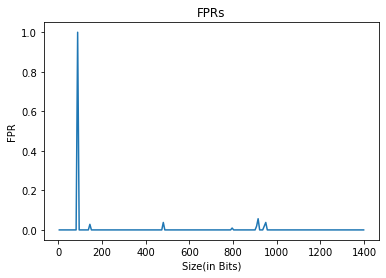

In [21]:
plt.plot(size_values,fpr_values)
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()

# Normal Bloom Filter Values

In [17]:
def ideal_fpr(m,n):
    k = eff_k(m,n,1)
    return (1-(1-(1/m))**(n*k))**k

In [30]:
print(sum(y_train))
print(len(y_train))

[357]
463


In [31]:
n = sum(y_train)
y_ideal = [ideal_fpr(x,n) for x in size_values]

In [ ]:
plt.plot(size_values,y_ideal)
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()

# FPR Comparison between Projection Model and Normal Bloom Filter

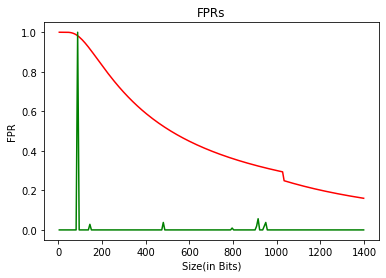

In [26]:
plt.plot(size_values,y_ideal,color='red')
plt.plot(size_values,fpr_values,color='green')
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()
# Red- Normal Bloom Filter
# Green- Projection Model

#  FPR Comparison between Kraska Hash Model, Projection Model and Normal Bloom Filter

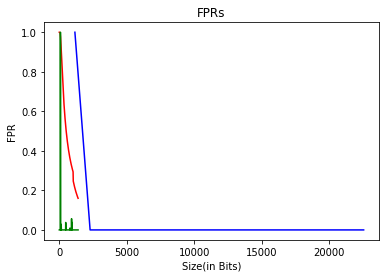

In [27]:
plt.plot(size_values,y_ideal,color='red')
plt.plot(size_values,fpr_values,color='green')
plt.plot(size_values_kraska,fpr_values_kraska,color='blue')
plt.title('FPRs')
plt.xlabel('Size(in Bits)')
plt.ylabel('FPR')
plt.show()
# Red- Normal Bloom Filter
# Green- Projection Model
# Blue- Kraska Hash Model

# Size comparisons

In [ ]:
fpr_values = []
size_values = []

In [33]:
def get_data_points_Projection2(x_train,x_test,y_train,epochs,fpr_values,size_values_kraska):
    input_dim = x_train.shape[1]
    n = sum(y_train)
    x_pos = x_train[(y_train==1).reshape(-1)]
    print(x_pos.shape)
    x_neg = x_train[(y_train==0).reshape(-1)]
    average_over = 3   # Increase to make the graph smoother
    for i in size_values_kraska:
        m = i
        k = eff_k(m,n,1)
        fpr = 1
        tempbf = Projection_BloomFilter(m,k,input_dim)   
        sum_fpr = 0
        for it in range(0,average_over):
            for j in range(0,epochs):
                bf = Projection_BloomFilter(m,k,input_dim)
                bf.bulk_add(x_pos)
                temp = find_fpr(bf,x_pos,x_neg)
                if(fpr>temp):
                    fpr = temp
                    tempbf=bf
            sum_fpr += find_fpr2(tempbf,x_test)
        fpr_test = sum_fpr/average_over
        print("Size: %d Bits - FPR: %f \n\n\n" % (m,fpr_test))
        fpr_values += [fpr_test]


In [34]:
get_data_points_Projection2(x_train,x_test,y_train,100,fpr_values,size_values_kraska)

(357, 30)
<ipython-input-16-b57e51f0f1a6>:21: RuntimeWarning: overflow encountered in exp
  norm_proj = 1/(1+np.exp(-projections)) #Sigmoid on each value so that they are in the range (0,1)
Size: 2113 Bits - FPR: 0.000000 



Size: 4161 Bits - FPR: 0.000000 



Size: 6209 Bits - FPR: 0.000000 



Size: 8257 Bits - FPR: 0.000000 



Size: 10305 Bits - FPR: 0.000000 



Size: 12353 Bits - FPR: 0.000000 



Size: 14401 Bits - FPR: 0.000000 



Size: 16449 Bits - FPR: 0.000000 



Size: 18497 Bits - FPR: 0.000000 



Size: 20545 Bits - FPR: 0.000000 



Size: 22593 Bits - FPR: 0.000000 



Size: 24641 Bits - FPR: 0.000000 



Size: 26689 Bits - FPR: 0.000000 



Size: 28737 Bits - FPR: 0.000000 



Size: 30785 Bits - FPR: 0.000000 



Size: 32833 Bits - FPR: 0.000000 



Size: 34881 Bits - FPR: 0.000000 



Size: 36929 Bits - FPR: 0.000000 



Size: 38977 Bits - FPR: 0.000000 



Size: 41025 Bits - FPR: 0.000000 





In [35]:
print(fpr_values)
print(len(fpr_values))

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
20


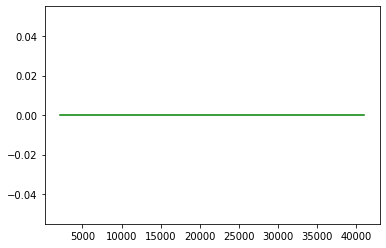

In [36]:
plt.plot(size_values_kraska,fpr_values,color='green')


In [37]:
n = sum(y_train)
y_ideal = [ideal_fpr(x,n) for x in size_values_kraska]

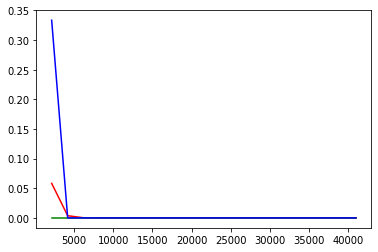

In [38]:
plt.plot(size_values_kraska,y_ideal,color='red') #ideal
plt.plot(size_values_kraska,fpr_values,color='green')
plt.plot(size_values_kraska,fpr_values_kraska,color='blue')